In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from multiprocessing import Pool
# from scipy import optimize as op

In [17]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

%matplotlib notebook

In [40]:
import uncertainties as unc

In [4]:
# df_NP = pd.read_csv('data/Au_NP.txt',sep='\t',header=18)
# df_base = pd.read_csv('data/HAuCl4_solution.txt',sep='\t',header=18)
# df_epsilon = pd.read_csv('data/epsilon_bulk_Au.txt',sep='\t')

# df_NP.to_csv('data/Au_NP.csv',index=False)
# df_base.to_csv('data/HAuCl4_solution.csv', index=False)
# df_epsilon.to_csv('data/epsilon_bulk_Au.csv',index=False)


df_NP = pd.read_csv('data/Au_NP.csv')
df_base = pd.read_csv('data/HAuCl4_solution.csv')
df_epsilon = pd.read_csv('data/epsilon_bulk_Au.csv')

def access(df,lam,key):
    lam_0 = df['lambda'][0]
    i = int(lam - lam_0)
    return df[key][i]

<IPython.core.display.Javascript object>


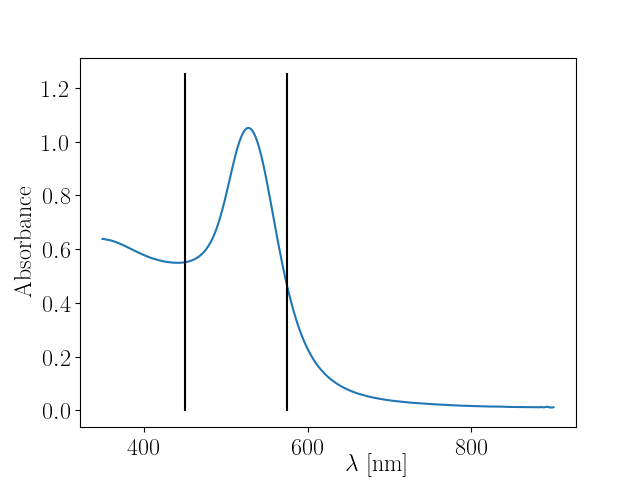

In [10]:
%matplotlib notebook
fit_range = [450,575]

name = 'raw_spectrum'

fig,ax = plt.subplots()
plt.plot(df_NP['lambda'],df_NP['A'])
# plt.plot(df_base['lambda'],df_base['A'])
plt.plot([fit_range[0],fit_range[0]],[0,1.25],color='black')
plt.plot([fit_range[1],fit_range[1]],[0,1.25],color='black')

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('Absorbance')
ax.xaxis.set_label_coords(0.6,-0.07)

# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

<IPython.core.display.Javascript object>


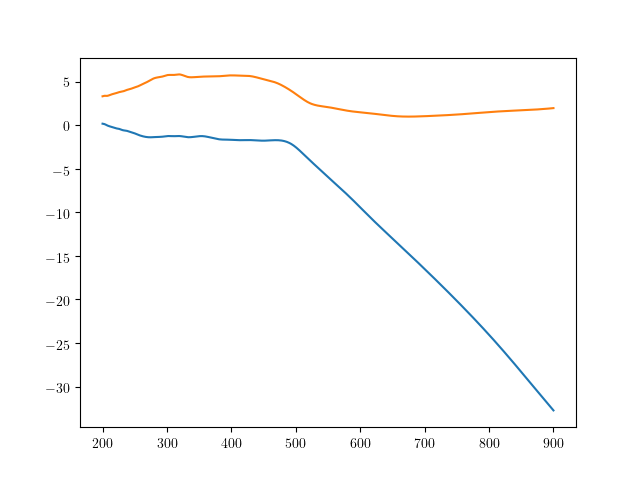

In [5]:
plt.figure()
plt.plot(df_epsilon['lambda'], df_epsilon['eps_1'])
plt.plot(df_epsilon['lambda'], df_epsilon['eps_2'])

In [14]:
z = 0.01*10**9 # thickness of the sample in nm


@np.vectorize
def absorbance(lam, eps_m, f):
    eps_1 = access(df_epsilon,lam,'eps_1')
    eps_2 = access(df_epsilon,lam,'eps_2')
    
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)
    


<IPython.core.display.Javascript object>


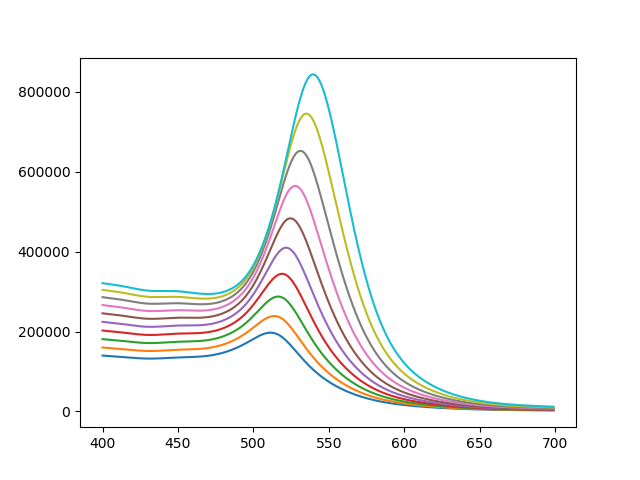

In [7]:
lams = np.arange(400,700)
eps_ms = np.linspace(1.1,1.6,10)**2

plt.figure()
for eps_m in eps_ms:
    As = absorbance(lams,eps_m,1)
    plt.plot(lams,As)

In [12]:
def r_chi2(func, xdata, ydata, args, ddof=0):
    '''
    func(x, *args)
    '''
    if ddof == 0:
        ddof = len(xdata) - len(args)
    return np.sum((ydata - func(xdata, *args))**2)/ddof

def make_args_list(args):
    '''
    args is a list of arrays: each of them contains the possible values for that parameter
    '''
    lens = [len(a) for a in args]
    return np.array(np.meshgrid(*args)).T.reshape(np.product(lens),len(lens))


def r_chi2_map(func, xdata, ydata, args_list, ofile='',columns=['eps_m','f','chi2']):
    df = pd.DataFrame(data=[],columns=columns)
    for args in tqdm(args_list):
        chi2 = r_chi2(func,xdata,ydata,args)
        df.loc[len(df)] = list(args) + [chi2]
    if ofile != '':
        df.to_csv(ofile,index=False)
    return df
    

## Without size correction

In [15]:
fs = np.linspace(1e-6,4e-6,100)
eps_ms = np.linspace(1.7,2.5,100)

lams = np.arange(450,575)
As = np.array([access(df_NP,lam,'A') for lam in lams])

r_chi2s = np.array(r_chi2_map(absorbance,lams,As,make_args_list([eps_ms,fs]))['chi2'])

100%|██████████| 10000/10000 [01:05<00:00, 152.77it/s]


In [21]:
print(np.min(r_chi2s))
make_args_list([eps_ms,fs])[np.argmin(r_chi2s)]

0.008743525658258967


array([2.10404040e+00, 2.06060606e-06])

<IPython.core.display.Javascript object>


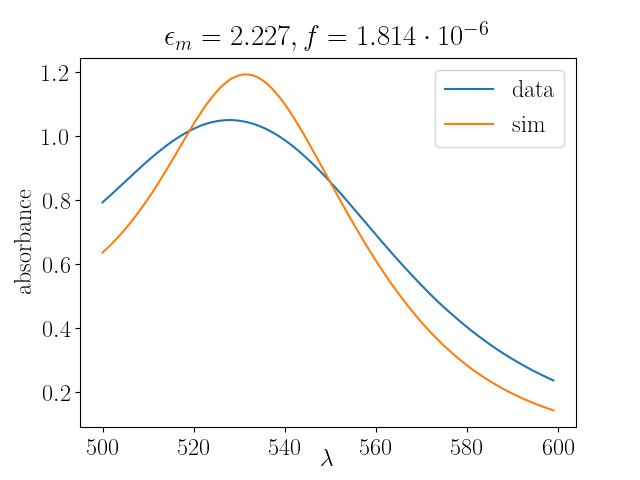

In [90]:
eps_m = 2.227
f = 1.814e-06

name = 'part1_fine_scan_500-600_best'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')
plt.plot(lams,absorbance(lams,eps_m,f),label='sim')
plt.legend()

plt.xlabel('$\lambda$')
plt.ylabel('absorbance')
plt.title('$\epsilon_m = %.3f, f = %.3f\cdot 10^{-6}$' %(eps_m,10**6*f))
ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

<IPython.core.display.Javascript object>


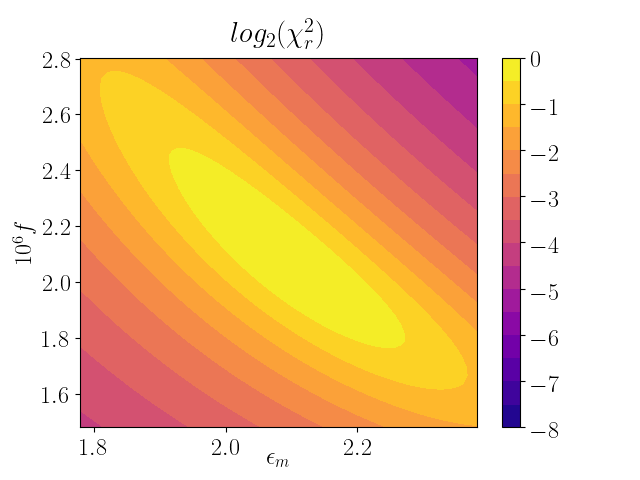

In [26]:
%matplotlib notebook
name = 'part1_coarse_scan_450-575'

Eps_m, F = np.meshgrid(eps_ms,fs)

min_chi2 = np.min(r_chi2s)


fig,ax = plt.subplots()
plt.contourf(Eps_m,1e6*F,np.log(min_chi2/r_chi2s.reshape(len(eps_ms),len(fs)).T)/np.log(2),
             levels=np.arange(-8,0.5,0.5),cmap='plasma')
plt.colorbar()

plt.xlabel('$\epsilon_m$')
plt.ylabel('$10^6 f$')
plt.title('$log_{2}(\chi_r^2)$')

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

## Size correction

In [43]:
import scipy.constants as cts

# m_Au = 196.967*cts.m_p # Au mass in Kg

## parameters from https://www.researchgate.net/figure/Optical-parameters-of-bulk-gold-used-and-determined-in-this-work_tbl1_231137746
omega_p = 13e15 # plasmon frequency in Hz
gamma_b = 1.1e14 # bulk damping frequency in Hz
E_F = 2.5 # Fermi energy in eV
v_F = np.sqrt(2*cts.e*E_F/cts.m_e)*10**9 # fermi velocity in nm/s


## parameters from  https://doi.org/10.1007/s11468-015-0128-7
omega_p = 9.01*cts.e/cts.hbar
v_F = 1.4*10**6*10**9

## parameters from Aschkrof-Mermin
n_e = 5.9e28
omega_p = np.sqrt(n_e*cts.e**2/(0.99*cts.m_e*cts.epsilon_0))
gamma_b = 1./9.3e-15
v_F = 1.4e06*10**9

In [11]:
'%e' %omega_p

'1.377209e+16'

In [8]:
v_F/10**9/10**6

0.9377686344728438

In [12]:
cts.hbar*omega_p/cts.e

9.064956051217143

In [44]:
def eps_SC(lam,R):
    omega = 2*np.pi*cts.c*10**9/lam
    
    eps_1_b = access(df_epsilon,lam,'eps_1')
    eps_2_b = access(df_epsilon,lam,'eps_2')
    
    gamma = gamma_b + np.pi/4*v_F/R
    
    eps_1 = eps_1_b + 1/((omega/omega_p)**2 + (gamma_b/omega_p)**2) - 1/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    eps_2 = eps_2_b - gamma_b/omega/((omega/omega_p)**2 + (gamma_b/omega_p)**2) + gamma/omega/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    return eps_1, eps_2

@np.vectorize
def absorbance_SC(lam,eps_m,rho,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*rho*(4*np.pi*R**3/3)*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)


@np.vectorize
def absorbance_SCf(lam,eps_m,f,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)

def absorbance_SCf_Rdist(lam,eps_m,f,R_values,R_probs):
    '''
    Assumes np.sum(R_probs) = 1
    '''
    absorb = 0.
    for i,R_v in enumerate(R_values):
        absorb += absorbance_SCf(lam,eps_m,f,R_v)*R_probs[i]
    return absorb


def r_chi2_SCf_pool(func,args_list,columns=['eps_m','f','R','chi2'],ofile=''):    
    p = Pool(6)
    values = p.map(func, tqdm(args_list))
    
    df = pd.DataFrame(data=values,columns=columns)
    
    if ofile != '':
        df.to_csv(ofile,index=False)
    return df

<IPython.core.display.Javascript object>


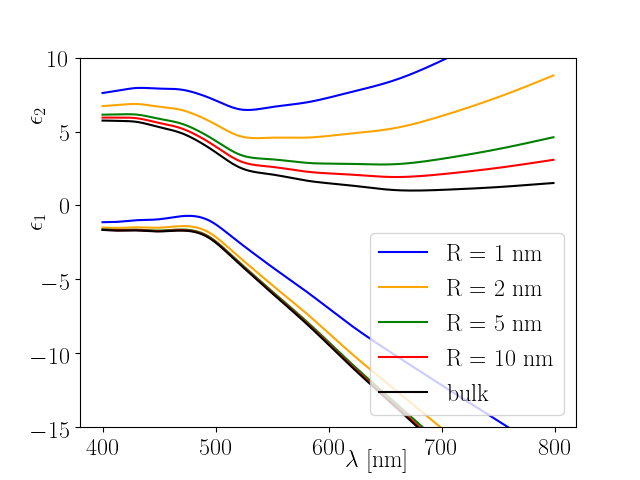

In [39]:
%matplotlib notebook

name = 'eps_SC'

Rs = [1,2,5,10]
colors = ['blue','orange','green','red']
lams = np.arange(400,800)

fig,ax = plt.subplots()

for i,R in enumerate(Rs):
    eps_1s = []
    eps_2s = []
    for lam in lams:
        eps_1, eps_2 = eps_SC(lam,R)
        eps_1s.append(eps_1)
        eps_2s.append(eps_2)

    plt.plot(lams,eps_1s,label='R = %d nm' %R,color=colors[i])
    plt.plot(lams,eps_2s,label='',color=colors[i])
    
plt.plot(lams,[access(df_epsilon,lam,'eps_1') for lam in lams],color='black',label='bulk')
plt.plot(lams,[access(df_epsilon,lam,'eps_2') for lam in lams],color='black',label='')
plt.legend()

plt.ylim(-15,10)

plt.xlabel('$\lambda$ [nm]')
plt.ylabel(r'$\epsilon_1 \qquad\qquad \epsilon_2$')

ax.xaxis.set_label_coords(0.6,-0.06)
ax.yaxis.set_label_coords(-0.06,0.7)

plt.savefig('../report/img/%s.png' %name)
plt.savefig('../report/img/%s.pgf' %name)

In [37]:
#SC with rho

rhos = np.linspace(4e-11,4e-7,100)
eps_ms = np.linspace(1.7,2.6,50)
Rs = np.arange(1,21)

lams = np.arange(400,700)
As = np.array([access(df_NP,lam,'A') for lam in lams])

df_chi2 = r_chi2_map(absorbance_SC,lams,As,make_args_list([eps_ms,rhos,Rs]),columns=['eps_m','rho','R','chi2'],
                     ofile='SC_chi2_map_scan_400-700_coarse.csv')

In [143]:
#SCf with f

fs = np.linspace(2.2e-6,3e-6,100)
eps_ms = np.linspace(1.9,2.14,50)
Rs = np.arange(2,6,0.2)

lams = np.arange(450,600)
As = np.array([access(df_NP,lam,'A') for lam in lams])

df_chi2 = r_chi2_map(absorbance_SCf,lams,As,make_args_list([eps_ms,fs,Rs]),columns=['eps_m','f','R','chi2'],
                     ofile='SCf_chi2_map_scan_450-600_fine.csv')

100%|██████████| 100000/100000 [18:06<00:00, 92.07it/s]


In [8]:
#SCf with f but faster

fs = np.linspace(1e-6,4e-6,300)
eps_ms = np.linspace(1.7,2.5,80)
Rs = np.linspace(2,20,180)

lams = np.arange(450,575)
As = np.array([access(df_NP,lam,'A') for lam in lams])

def evaluate(args):
    return list(args) + [r_chi2(absorbance_SCf,lams,As,args)]

df_chi2 = r_chi2_SCf_pool(evaluate,make_args_list([eps_ms,fs,Rs]),columns=['eps_m','f','R','chi2'],
                     ofile='')

100%|██████████| 4320000/4320000 [1:31:07<00:00, 834.97it/s]  


In [17]:
df_chi2.to_csv('../../large_files/SCf_chi2_map_scan_450-575_coarse_am.csv',index=False)

In [45]:
df_chi2 = pd.read_csv('../../large_files/SCf_chi2_map_scan_450-575_coarse_am.csv')
fs = np.linspace(1e-6,4e-6,300)
eps_ms = np.linspace(1.7,2.5,80)
Rs = np.linspace(2,20,180)

lams = np.arange(450,575)
As = np.array([access(df_NP,lam,'A') for lam in lams])

In [46]:
def integrate(df,free_axes,int_axis,v_min,v_max):  ## this way it does not work
    keys = df.keys()
    new_df = pd.DataFrame(data=[],columns=[keys[j] for j in free_axes] + ['chi2'])
    old_pars = []
    pars = []
    for i in tqdm(range(len(df))):
        v = df[keys[int_axis]][i]
        if v >= v_min and v <= v_max:
            pars = [df[keys[j]][i] for j in free_axes]
            found = False
            for h in range(1,len(old_pars)+1):
                p = old_pars[len(old_pars) - h]
                if p == pars:
                    new_df['chi2'][len(old_pars) - h] += df['chi2'][i]
                    found = True
                    break
            if not found:
                old_pars.append(pars)
                new_df.loc[len(new_df)] = pars + [df['chi2'][i]]
    
    return new_df

def cut(df,free_axes,int_axis,v_t):
    keys = df.keys()
    new_df = pd.DataFrame(data=[],columns=[keys[j] for j in free_axes] + ['chi2'])
    first_time = True
    pars = []
    for i in tqdm(range(len(df))):
        v = df[keys[int_axis]][i]
        if first_time:
            if v >= v_t:
                first_time = False
                v_t = v
        if not first_time:
            if v == v_t:
                pars = [df[keys[j]][i] for j in free_axes]
                new_df.loc[len(new_df)] = pars + [df['chi2'][i]]
    
    return new_df, v_t

def marginal_likelihood(df,key,coeff=1):
    values = []
    likelihood = []
    
    for i in tqdm(range(len(df))):
        value = df[key][i]
        found = False
        for j,v in enumerate(values):
            if v == value:
                likelihood[j] += np.exp(-df['chi2'][i]*coeff)
                found = True
                break
        if not found:
            values.append(value)
            likelihood.append(np.exp(-df['chi2'][i]*coeff))
            
    s = np.sum(likelihood)
    return np.array(values), np.array(likelihood)/s

In [55]:
i_min = np.argmin(np.array(df_chi2['chi2']))
chi_min = df_chi2['chi2'][i_min]

print(df_chi2.keys(),i_min)
df_chi2.loc[i_min]

Index(['eps_m', 'f', 'R', 'chi2'], dtype='object') 754360


eps_m    2.044304
f        0.000003
R        5.117318
chi2     0.000775
Name: 754360, dtype: float64

In [12]:
df_chi2['f'][i_min]

2.6053511705685617e-06

<IPython.core.display.Javascript object>


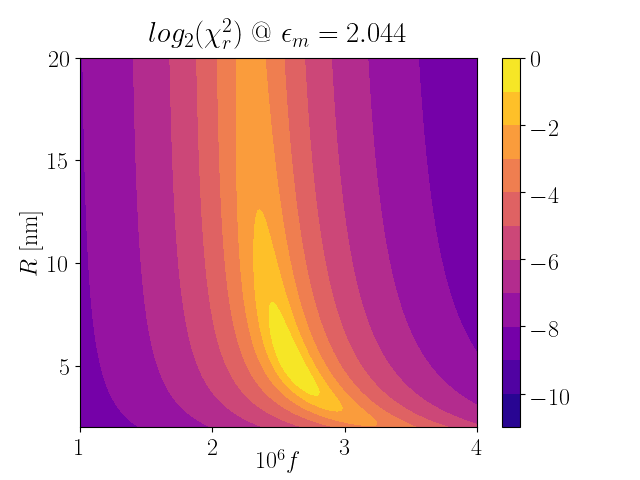

In [15]:
%matplotlib notebook
v_min = 2.044 #eps_m

name = 'part1_am_coarse_scan_450-575_Rf_SCf'

# df_eps_m, v_actual_eps_m = cut(df_chi2,[1,2],0,v_min)
chi2s = np.array(df_eps_m['chi2']).reshape(len(Rs),len(fs))
xs = 10**6*np.array(df_eps_m['f']).reshape(len(Rs),len(fs))
ys = np.array(df_eps_m['R']).reshape(len(Rs),len(fs))

fig,ax = plt.subplots()
plt.contourf(xs,ys,-np.log(chi2s/chi_min)/np.log(2),levels=np.arange(-11,1),cmap='plasma')
plt.xlabel('$10^6f$')
plt.ylabel('$R$ [nm]')
plt.title(r'$log_2 (\chi_r^2)$ @ $\epsilon_m = %.3f$' %v_actual_eps_m)
plt.colorbar()

ax.xaxis.set_label_coords(0.5,-0.06)

# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

100%|██████████| 4320000/4320000 [01:56<00:00, 37204.26it/s]


<IPython.core.display.Javascript object>


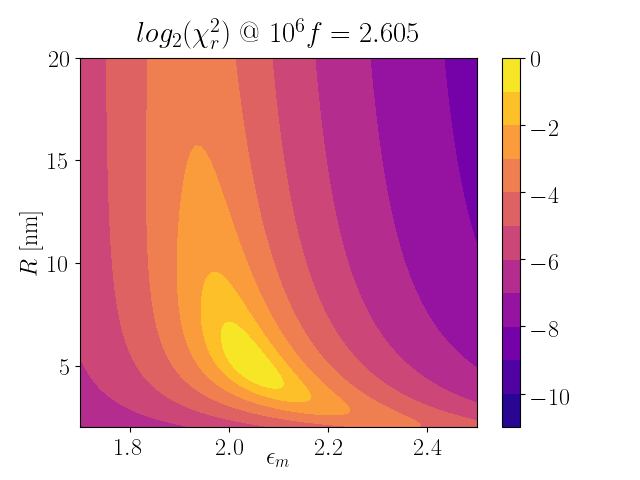

In [16]:
v_min = 2.605e-6 # f

name = 'part1_am_coarse_scan_450-575_Re_SCf'

# df_f, v_actual_f = cut(df_chi2,[0,2],1,v_min)
chi2s = np.array(df_f['chi2']).reshape(len(Rs),len(eps_ms))
xs = np.array(df_f['eps_m']).reshape(len(Rs),len(eps_ms))
ys = np.array(df_f['R']).reshape(len(Rs),len(eps_ms))


fig,ax = plt.subplots()
plt.contourf(xs,ys,-np.log(chi2s/chi_min)/np.log(2),levels=np.arange(-11,1),cmap='plasma')
plt.xlabel('$\epsilon_m$')
plt.ylabel('$R$ [nm]')
plt.title(r'$log_2 (\chi_r^2)$ @ $10^6 f = %.3f$' %(10**6*v_actual_f))
plt.colorbar()

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

100%|██████████| 4320000/4320000 [02:04<00:00, 34811.40it/s]


<IPython.core.display.Javascript object>


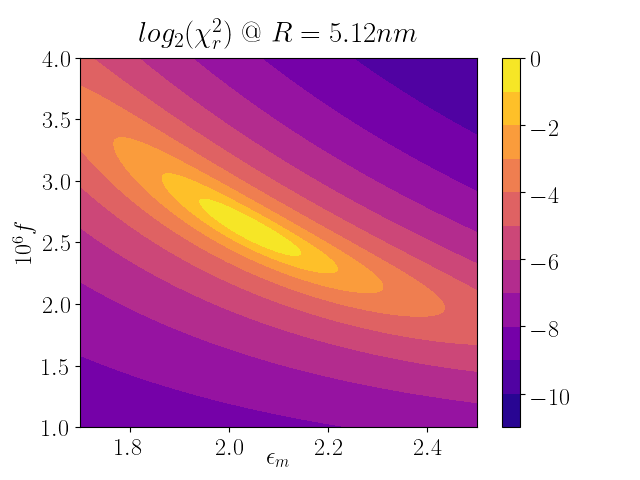

In [17]:
v_min = 5.117 # R

name = 'part1_am_coarse_scan_450-575_fe_SCf'

# df_R,v_actual_R = cut(df_chi2,[0,1],2,v_min)
chi2s = np.array(df_R['chi2']).reshape(len(eps_ms),len(fs)).T
xs = np.array(df_R['eps_m']).reshape(len(eps_ms),len(fs)).T
ys = 10**6*np.array(df_R['f']).reshape(len(eps_ms),len(fs)).T

fig,ax = plt.subplots()
plt.contourf(xs,ys,-np.log(chi2s/chi_min)/np.log(2),levels=np.arange(-11,1),cmap='plasma')
plt.xlabel('$\epsilon_m$')
plt.ylabel('$10^6 f$')
plt.title(r'$log_2 (\chi_r^2)$ @ $R = %.2f nm$' %(v_actual_R))
plt.colorbar()

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

In [29]:
df_chi2.loc[i_min]

eps_m    2.044304
f        0.000003
R        5.117318
chi2     0.000775
Name: 754360, dtype: float64

<IPython.core.display.Javascript object>


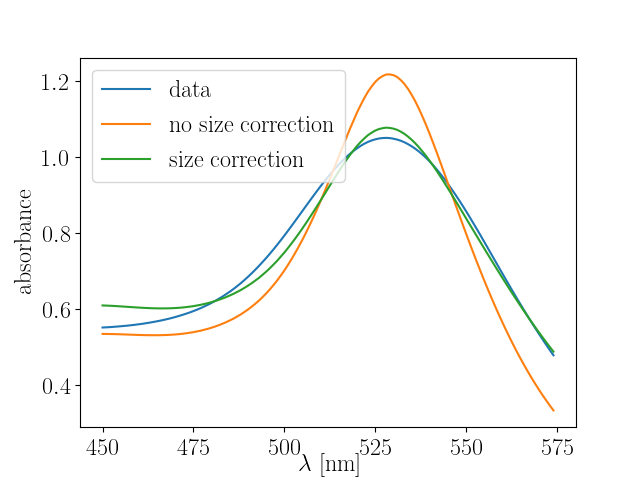

In [86]:
name = 'part1_am_coarse_scan_450-575_best'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')

eps_m = 2.104
f = 2.061e-06

plt.plot(lams,absorbance(lams,eps_m,f),label='no size correction')

eps_m = 2.044
f = 2.605e-6
R = 5.117

plt.plot(lams,absorbance_SCf(lams,eps_m,f,R),label='size correction')
plt.legend()

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('absorbance')
# plt.title(r'$\epsilon_m = %.3f, f = %.2f\cdot 10^{-6}, R = %d nm$' %(eps_m,10**6*f,R))
ax.xaxis.set_label_coords(0.505,-0.07)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

100%|██████████| 4320000/4320000 [04:17<00:00, 16747.96it/s]


<IPython.core.display.Javascript object>


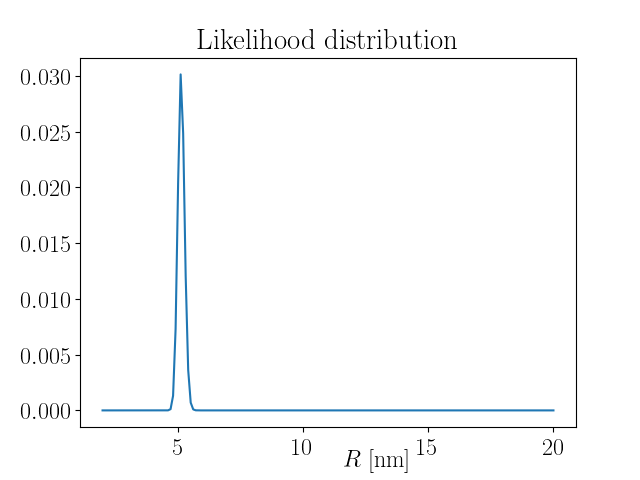

In [74]:
## likelihood integrating for R

%matplotlib notebook

Rss_i, likess_i = marginal_likelihood(df_chi2,'R',coeff=1.*len(lams)/chi_min)
Rss, likess = Rss_i, likess_i

name = 'part1_am_coarse_scan_450-575_likelihood_R'

fig,ax = plt.subplots()
plt.plot(Rss,likess*(Rss[1] - Rss[0]))
plt.xlabel('$R$ [nm]')
plt.title('Likelihood distribution')
ax.xaxis.set_label_coords(0.6,-0.06)


# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

In [53]:
R_m = np.sum(Rss*likess)
R_std = np.sqrt(np.sum(Rss**2*likess) - R_m**2)
print(R_m,R_std)

6.300748331891548 2.465175697514602


<IPython.core.display.Javascript object>


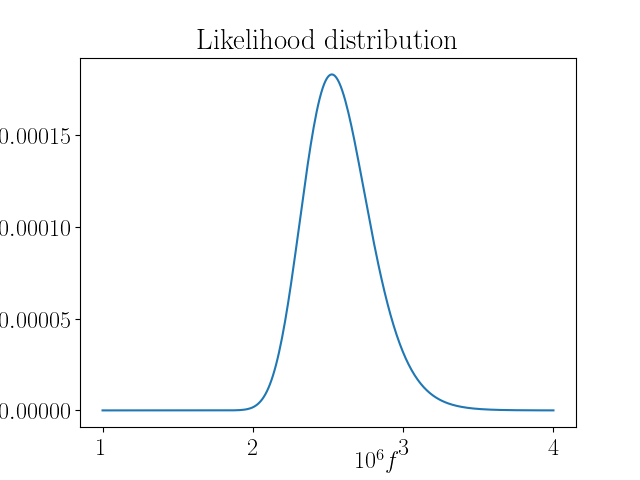

In [52]:
## likelihood integrating for f

%matplotlib notebook

# fss_i, flikess_i = marginal_likelihood(df_chi2,'f',coeff=1./chi_min)

name = 'part1_am_coarse_scan_450-575_likelihood_f'

fig,ax = plt.subplots()
plt.plot(10**6*fss_i,flikess_i*(fss_i[1] - fss_i[0])*10**6)
plt.xlabel('$10^6f$')
plt.title('Likelihood distribution')
ax.xaxis.set_label_coords(0.6,-0.06)


# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

In [54]:
f_m = np.sum(fss_i*flikess_i)
f_std = np.sqrt(np.sum(fss_i**2*flikess_i) - f_m**2)
print(f_m,f_std)

2.579703282542498e-06 2.2923446536426106e-07


<IPython.core.display.Javascript object>


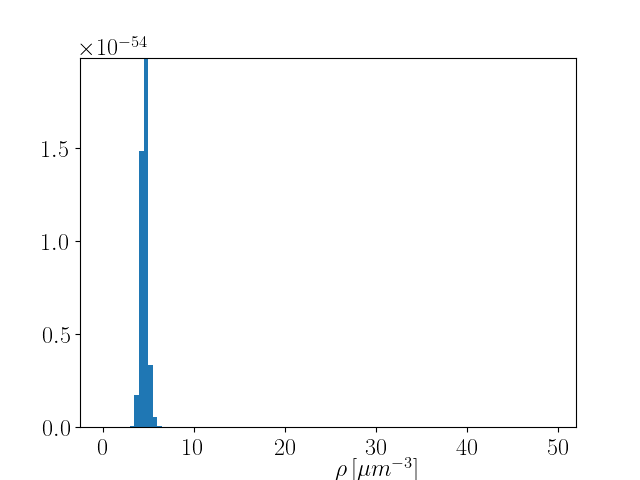

In [73]:
fig,ax = plt.subplots()
plt.hist(np.array(df_chi2['f'])/(4*np.pi/3*np.array(df_chi2['R']**3))*10**9,
         weights=np.exp(-np.array(df_chi2['chi2'])/(chi_min)*len(lams)),
        bins = np.arange(0,50,0.5))
plt.xlabel(r'$\rho\,[\mu m^{-3}]$')
ax.xaxis.set_label_coords(0.6,-0.08)

In [58]:
# compute rho

rho1 = 0.
rho2 = 0.
lsum = 0.
for i in tqdm(range(len(df_chi2))):
    rho = df_chi2['f'][i]/(4*np.pi/3*df_chi2['R'][i]**3)
    l = np.exp(-df_chi2['chi2'][i]/chi_min)
    rho1 += rho*l
    rho2 += rho**2*l
    lsum += l

rho_m = rho1/lsum
rho_std = np.sqrt(rho2/lsum - rho_m**2)
print(rho_m,rho_std)

100%|██████████| 4320000/4320000 [05:37<00:00, 12809.72it/s]

4.993215226164223e-09 5.657541547406801e-09


100%|██████████| 14400/14400 [00:00<00:00, 42233.96it/s]


<IPython.core.display.Javascript object>


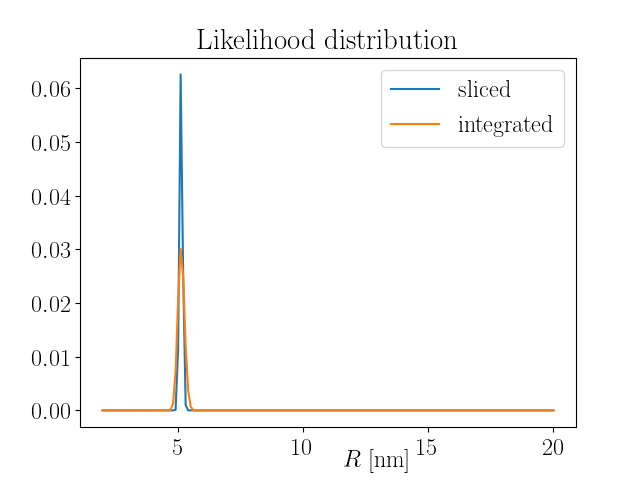

In [75]:
## likelihood slicing

%matplotlib notebook

df_f, v_actual_f = cut(df_chi2,[0,2],1,2.605e-6)
df_Rss, v_actual_eps_m = cut(df_f,[1],0,2.044)

Rss = df_Rss['R']
likess = np.exp(-np.array(df_Rss['chi2'])*len(lams)/chi_min)
likess /= np.sum(likess)

name = 'part1_am_coarse_scan_450-575_likelihood_R2'

fig,ax = plt.subplots()
plt.plot(Rss,likess*(Rss[1] - Rss[0]),label='sliced')
plt.plot(Rss,likess_i*(Rss[1] - Rss[0]),label='integrated')
plt.xlabel('$R$ [nm]')
plt.title('Likelihood distribution')
plt.legend()

ax.xaxis.set_label_coords(0.6,-0.06)


# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

In [45]:
np.sum(likess)

1.0

In [28]:
Rss[np.argmax(likess)]

4.916201117318437

In [17]:
eps_m = 2.044
f = 2.605e-6
R = 5.117

chi_dist = r_chi2(absorbance_SCf_Rdist,lams,As,[eps_m,f,Rss,likess])

name = 'part1_am_coarse_scan_450-575_best_SCf_Rdist_sliced'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')
plt.plot(lams,absorbance_SCf(lams,eps_m,f,R),label='monodispersed')
plt.plot(lams,absorbance_SCf_Rdist(lams,eps_m,f,Rss,likess),label='dist sliced')
plt.plot(lams,absorbance_SCf_Rdist(lams,eps_m,f,Rss,likess_i),label='dist integrated')
plt.legend()

plt.xlabel('$\lambda$')
plt.ylabel('absorbance')
plt.title(r'$\epsilon_m = %.3f, f = %.2f\cdot 10^{-6}$' %(eps_m,10**6*f))
ax.xaxis.set_label_coords(0.5,-0.06)

# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

NameError: name 'Rss' is not defined

## interactive fit

In [11]:
from ipywidgets import interact, fixed

%matplotlib notebook

# def log_normal(Rss, R_star,sigma):
#     R_probs = np.zeros_like(Rss)
#     for i,R in enumerate(Rss):
#         R_probs[i] = np.exp(-0.5*((np.log(R) - np.log(R_star))**2/np.log(sigma))**2)/R
        
#     return R_probs/np.sum(R_probs)

def plot(lams,As,Rss,eps_m,f,R_star,sigma):
    plt.figure()
    plt.plot(lams,As)
    lss = log_normal(Rss,R_star,sigma)
    plt.plot(lams,absorbance_SCf_Rdist(lams,eps_m,f/10**6,Rss,lss))
    plt.title(r'$\chi^2/\chi_{min}^2 = %.7f$' %(r_chi2(absorbance_SCf_Rdist,lams,As,
                                          [eps_m,f/10**6,Rss,lss],ddof=len(lams)-3)/chi_min))
    plt.show()


interact(plot, lams=fixed(lams), As = fixed(As), Rss=fixed(Rss),
         eps_m = 2.044, f = 2.605, R_star=5.11, sigma= (0.1,10))

NameError: name 'Rss' is not defined

# 3D plot: stability basin

In [70]:
from mpl_toolkits.mplot3d import Axes3D

In [59]:
# df = pd.read_csv('./SCf_chi2_map_scan_450-600_fine.csv')
df = df_chi2
min_chi2 = np.min(df['chi2'])
print(min_chi2)
df.keys()

0.0007749116248225267


Index(['eps_m', 'f', 'R', 'chi2'], dtype='object')

<IPython.core.display.Javascript object>


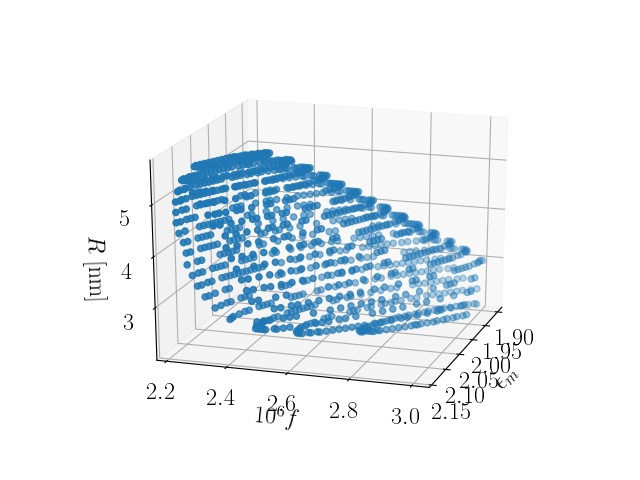

100%|██████████| 100000/100000 [00:01<00:00, 91249.26it/s]


In [55]:
u = 2
l = 1.9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$\epsilon_m$')
ax.set_ylabel('$10^6 f$')
ax.set_zlabel('$R$ [nm]')

xs = []
ys = []
zs = []
for i in tqdm(range(len(df))):
    if df['chi2'][i] < u*min_chi2 and df['chi2'][i] > l*min_chi2:
        xs.append(df['eps_m'][i])
        ys.append(df['f'][i]*10**6)
        zs.append(df['R'][i])

# ax.plot_trisurf(xs,ys,zs)
ax.scatter(xs,ys,zs)

<IPython.core.display.Javascript object>


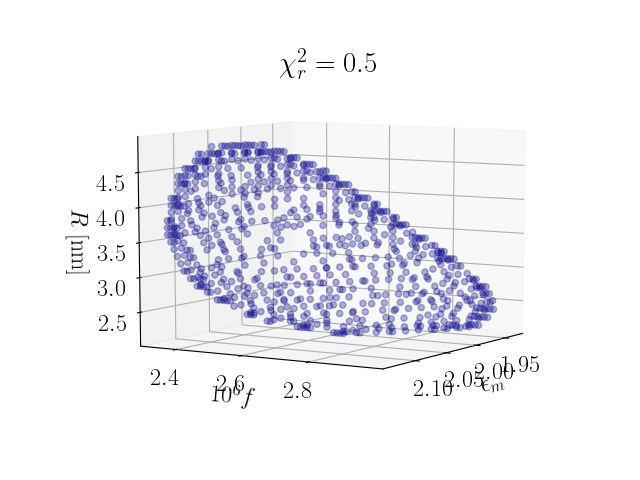

100%|██████████| 4320000/4320000 [01:42<00:00, 42110.20it/s]


In [74]:
%matplotlib notebook
lus = [[1,1.1],[1.9,2]][1:]
colors = ['darkblue', 'lightblue']

compute = False

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$\epsilon_m$')
ax.set_ylabel('$10^6 f$')
ax.set_zlabel('$R$ [nm]')
ax.set_title('$\chi_r^2 = 0.5$')
# ax.xaxis.set_label_coords(0.5,-0.06,0)
ax.yaxis.set_label_coords(-0.1,0.5,0)


for j,(l,u) in enumerate(lus):
    if compute:
        xs = []
        ys = []
        zs = []
        for i in tqdm(range(len(df))):
            if df['chi2'][i] < u*min_chi2 and df['chi2'][i] > l*min_chi2:
                xs.append(df['eps_m'][i])
                ys.append(df['f'][i]*10**6)
                zs.append(df['R'][i])

    # ax.plot_trisurf(xs,ys,zs)
    ax.scatter(xs,ys,zs, color=colors[j],alpha=0.3)

# Shape correction

In [14]:
@np.vectorize
def absorbance_SCsf(lam,eps_m,f,R,e):
    if e < 0.001:
        return absorbance_SCf(lam,eps_m,f,R)
    
    eps_1, eps_2 = eps_SC(lam,R)
    e1 = 1./e
    L1 = (e1**2 - 1)*(0.5*e1*np.log((1 + e)/(1 - e)) - 1)
    L2 = 0.5*(1. - L1)
    s1 = eps_2/L1**2/((eps_1 + eps_m*(1 - L1)/L1)**2 + eps_2**2)
    s2 = eps_2/L2**2/((eps_1 + eps_m*(1 - L2)/L2)**2 + eps_2**2)
    return 2./3.*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*(s1 + 2*s2)

@np.vectorize
def aspect_ratio(e):
    return 1./np.sqrt(1 - e**2)

@np.vectorize
def e_from_aspr(ar):
    return(np.sqrt(1 - 1./ar**2))

In [15]:
# df_chi2 = pd.read_csv('../../large_files/SCf_chi2_map_scan_450-575_coarse_am.csv')

# lams = np.arange(450,575)
# As = np.array([access(df_NP,lam,'A') for lam in lams])

# min_chi2 = np.min(df_chi2['chi2'])
# i_min = np.argmin(np.array(df['chi2']))

# eps_m = df_chi2['eps_m'][i_min]
# f = df_chi2['f'][i_min]
# R = df_chi2['R'][i_min]

print(min_chi2/r_chi2(absorbance_SCsf,lams,As,[eps_m,f,R,0.],ddof=len(lams)-3))

NameError: name 'min_chi2' is not defined

<IPython.core.display.Javascript object>


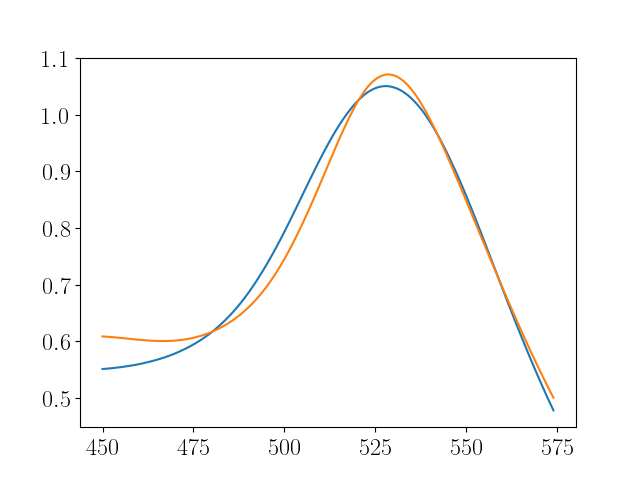

In [21]:
fig,ax = plt.subplots()
plt.plot(lams,As)
plt.plot(lams,absorbance_SCsf(lams,eps_m,f,5,0.377))

0.377


<IPython.core.display.Javascript object>


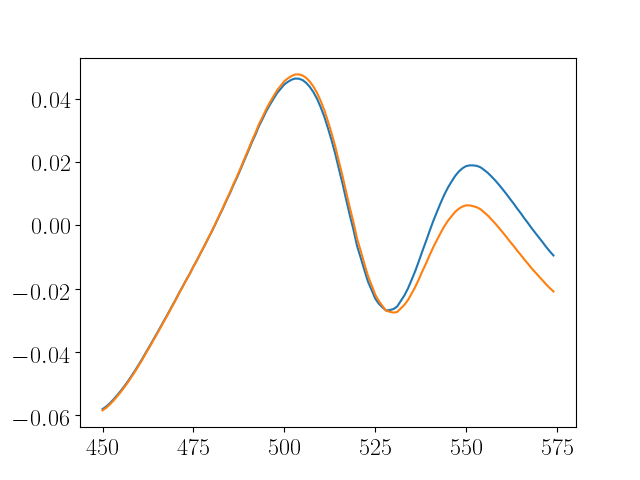

In [28]:
# eps_m = 2.044
# f = 2.605e-6
# R = 5.117
e = e_from_aspr(1.25)
e = 0.377
print(e)

fig,ax = plt.subplots()
ax.plot(lams,As - absorbance_SCf(lams,eps_m,f,R))
ax.plot(lams,As - absorbance_SCsf(lams,eps_m,f,R,e))
# ax.plot(lams,As - absorbance_SCsf(lams,eps_m,f,5,0))
# ax.plot(lams,absorbance_SCsf(lams,eps_m,f,R,e) - absorbance_SCf(lams,eps_m,f,R))

<IPython.core.display.Javascript object>


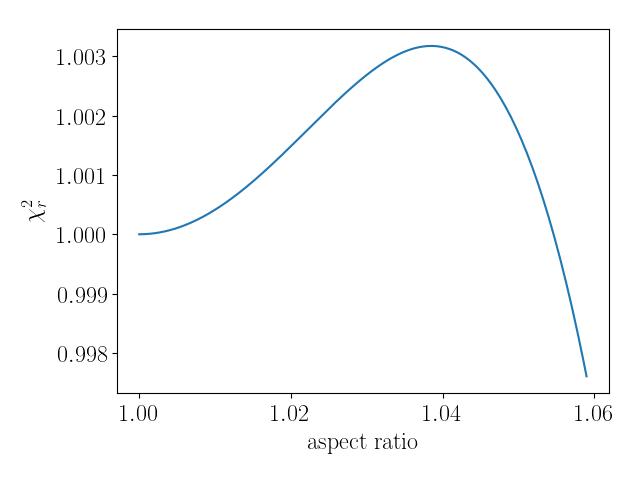

In [95]:
%matplotlib notebook
es = np.arange(0.0,0.33,0.001)

name = 'part1_am_coarse_scan_450-575_shape_effect'

chi2s = []
for e in es:
    chi2s.append(r_chi2(absorbance_SCsf,lams,As,[eps_m,f,R,e],ddof=len(lams)-3))
chi2s = np.array(chi2s)
    
fig,ax = plt.subplots()
plt.plot(aspect_ratio(es),min_chi2/chi2s)
# plt.plot(es,min_chi2/chi2s)
plt.xlabel('aspect ratio')
plt.ylabel('$\chi_r^2$')

fig.tight_layout()

# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

In [22]:
@np.vectorize
def L1(e):
    e1 = 1./e
    L1 = (e1**2 - 1)*(0.5*e1*np.log((1 + e)/(1 - e)) - 1)
    return L1

<IPython.core.display.Javascript object>


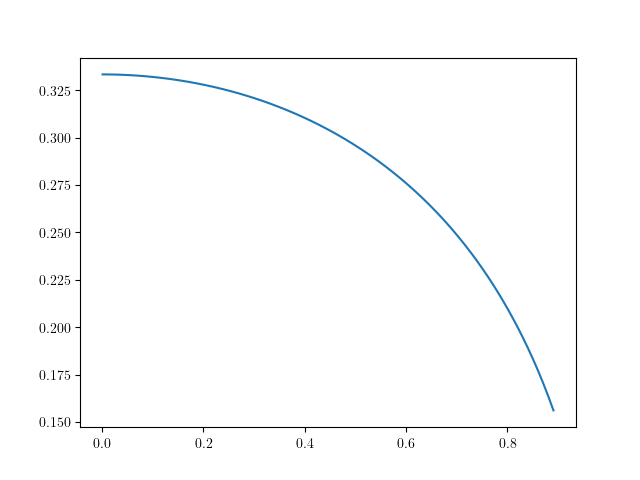

In [23]:
es = np.arange(0.001,0.9,0.01)

plt.figure()
plt.plot(es,L1(es))